# Lab 10

This lab will focus mainly on modeling, and specifically on fitting various regression models using Pokemon!

## Table of Contents
* [Review/Explore](#Review/Explore)
* [Exercises](#Exercises)

In [1]:
library(tidyverse)
library(stringr)
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Review/Explore

### Modeling - Setup

The lecture notes have done a thorough job of explaining the setup of a statistical model. But in general when we model data we are trying to predict some output `y`, based on the some inputs, `x`, with some estimated error, epsilon.

$$\underbrace{Y}_{\text{outcome}} = \underbrace{f}_{\text{model function}}(\underbrace{X}_{\text{explainer}}) + 
    \underbrace{\epsilon}_\text{noise}$$

Where f(x) could be any type of model we think fits well with the data (e.g. fitting a line to the data, fitting a parabola to the data, fitting a series of curved lines, etc.) and the 'noise' here refers to the fact that we know our model isn't going to perfectly fit the data.

### Exploring with Pokemon

To walk through some of these concepts and explain modeling techniques, we will use a dataset that contains stats about different types of Pokemon. Let's take a look at the data a bit.

In [2]:
#Read data
poke = read.csv('Pokemon.csv')
names(poke)
head(poke)

[1] "X."         "Name"       "Type.1"     "Type.2"     "Total"     
 [6] "HP"         "Attack"     "Defense"    "Sp..Atk"    "Sp..Def"   
[11] "Speed"      "Generation" "Legendary"

X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,,309,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,,405,58,64,58,80,65,80,1,False


In [3]:
#Let's take a look at the variables here
summary(poke)

       X.                             Name         Type.1         Type.2   
 Min.   :  1.0   Abomasnow              :  1   Water  :112           :386  
 1st Qu.:184.8   AbomasnowMega Abomasnow:  1   Normal : 98   Flying  : 97  
 Median :364.5   Abra                   :  1   Grass  : 70   Ground  : 35  
 Mean   :362.8   Absol                  :  1   Bug    : 69   Poison  : 34  
 3rd Qu.:539.2   AbsolMega Absol        :  1   Psychic: 57   Psychic : 33  
 Max.   :721.0   Accelgor               :  1   Fire   : 52   Fighting: 26  
                 (Other)                :794   (Other):342   (Other) :189  
     Total             HP             Attack       Defense      
 Min.   :180.0   Min.   :  1.00   Min.   :  5   Min.   :  5.00  
 1st Qu.:330.0   1st Qu.: 50.00   1st Qu.: 55   1st Qu.: 50.00  
 Median :450.0   Median : 65.00   Median : 75   Median : 70.00  
 Mean   :435.1   Mean   : 69.26   Mean   : 79   Mean   : 73.84  
 3rd Qu.:515.0   3rd Qu.: 80.00   3rd Qu.:100   3rd Qu.: 90.00  
 M

In [4]:
#Now let's see if any of the numeric variables have any correlation
# (which could tell us if linear regression would be a good model to try)
cor(poke[,6:12])

,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation
HP,1.00000000,0.42238603,0.23962232,0.36237986,0.37871807,0.17595206,0.05868251
Attack,0.42238603,1.00000000,0.43868706,0.39636176,0.26398955,0.38123974,0.05145134
Defense,0.23962232,0.43868706,1.00000000,0.22354861,0.51074659,0.01522660,0.04241857
Sp..Atk,0.36237986,0.39636176,0.22354861,1.00000000,0.50612142,0.47301788,0.03643683
Sp..Def,0.37871807,0.26398955,0.51074659,0.50612142,1.00000000,0.25913311,0.02848599
Speed,0.17595206,0.38123974,0.01522660,0.47301788,0.25913311,1.00000000,-0.02312106
Generation,0.05868251,0.05145134,0.04241857,0.03643683,0.02848599,-0.02312106,1.00000000


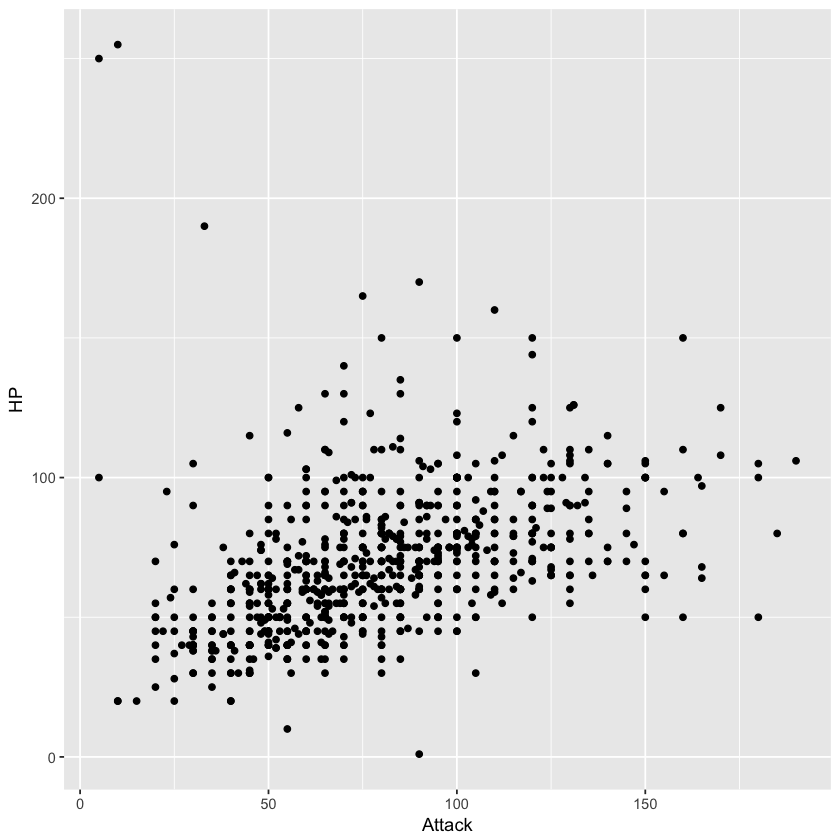

In [5]:
#It looks like HP and attack have a fairly high positive correlation, let's look at a scatter to inspect
ggplot() + geom_point(data=poke, mapping = aes(x=Attack, y=HP))

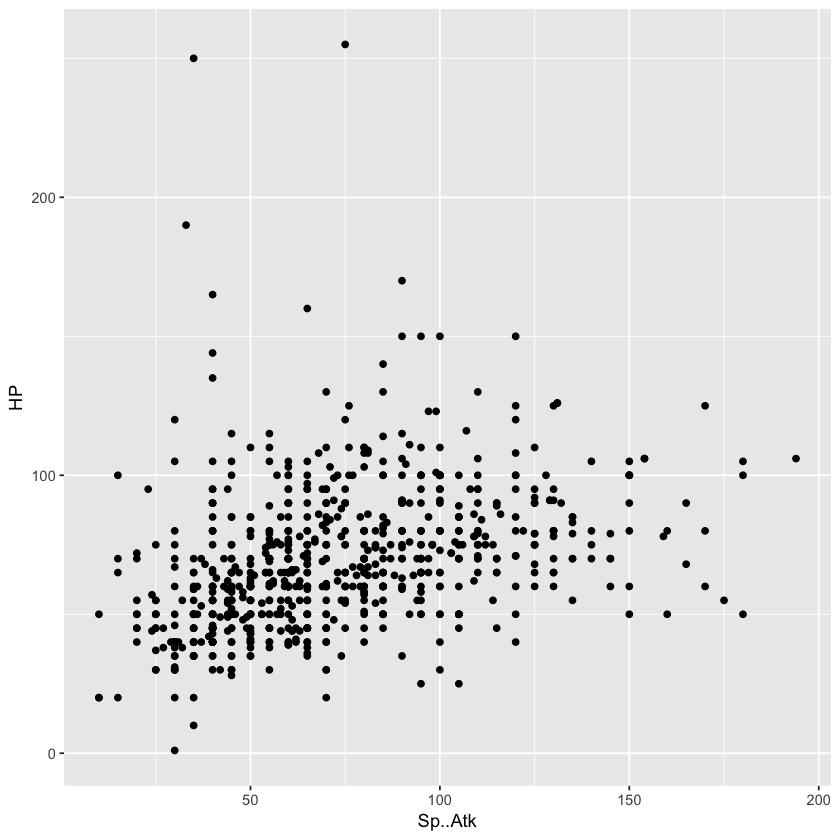

In [6]:
# Attack looks to have a strong relationship, but let's also look at Speed Attack
ggplot() + geom_point(data=poke, mapping = aes(x=Sp..Atk, y=HP))

### Determining the model

Based on the initial exploration above, it looks like a linear model may be a good fit if we wanted to predict the HP variable based on the attack variables in the dataset. Or the model we are trying to fit in this case would look generally like this:

$$y = a_1 + a_2 x$$

Or specific to our question, like this:

$$HP = Intercept +  Coefficient1 * Attack + Coefficient2 * Sp.Atk $$

Where this means that we are using the attack and sp. attack variables of many Pokemon to try to predict the HP of any new Pokemon we haven't seen.

### Fitting the model

Now that we have decided to use a linear model, we can move on to trying to fit the model to our data. This is where R really shines! R has many optimized functions that enable us to fit many, manyyyy, different types of models. If you read about a model in a journal article or in the news (e.g. random forest, support vector machines, linear, C4.5, kNN, etc etc) just google 'R, model name' and you will find a great function to try to use.

For our problem, the most common simple linear regression function used in R is lm().

In [8]:
# Most of the model fitting functions in R use a very nice format: y ~ x1 + x2 + ... 
# Many functions in R follow this format regardless of the model chosen, just read the documentation of a function
# if you are at all uncertain about what format to use
mdl = lm(HP ~ Attack + Sp..Atk, data = poke)

In [9]:
#Now that I fit my model, I can use the summary function to see a few details about the model
summary(mdl)


Call:
lm(formula = HP ~ Attack + Sp..Atk, data = poke)

Residuals:
    Min      1Q  Median      3Q     Max 
-64.881 -12.798  -3.558   8.137 206.821 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 35.56126    2.36550  15.033  < 2e-16 ***
Attack       0.26017    0.02675   9.727  < 2e-16 ***
Sp..Atk      0.18049    0.02653   6.803 2.01e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 22.53 on 797 degrees of freedom
Multiple R-squared:  0.2235,	Adjusted R-squared:  0.2216 
F-statistic: 114.7 on 2 and 797 DF,  p-value: < 2.2e-16


In [10]:
#Note how many extra variables get created when you fit a model
names(mdl)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

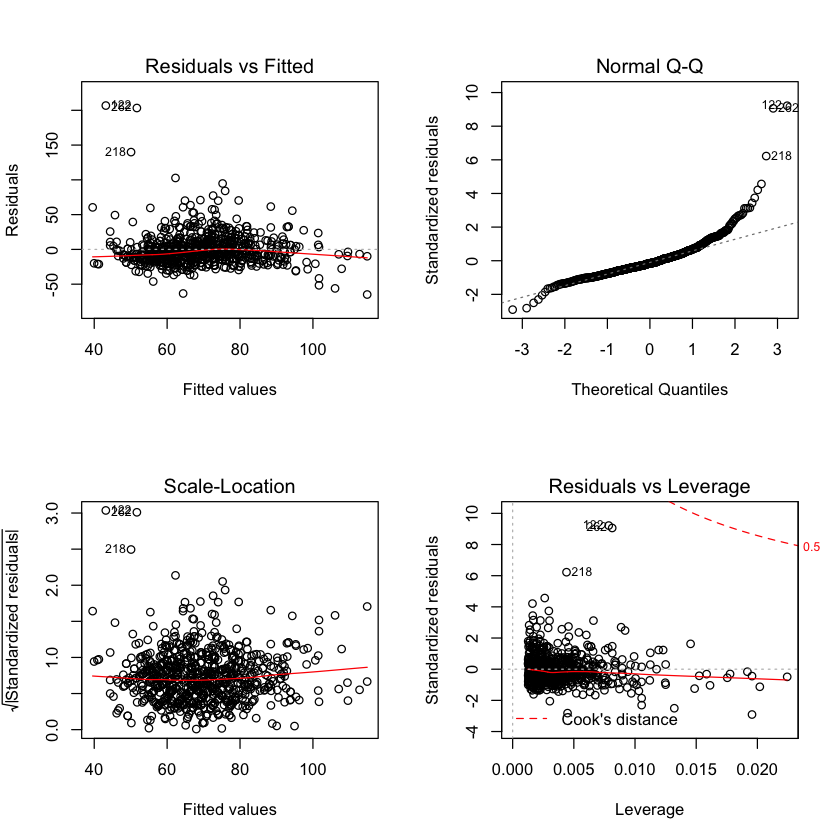

In [44]:
#Also notice that using the standard plot() function gives you some nice diagnostics plots
par(mfrow = c(2,2))
plot(mdl)

In [11]:
#Tidyverse has a few nice functions that let you add the residuals and predictions (and other things) directly to the model
#Notice that using the built in residuals (mdl$residuals) leads to the same results
head(mdl$residuals)
head(poke %>% add_residuals(mdl) %>% add_predictions(mdl))

1          2          3          4          5          6 
-15.041795  -6.131441   5.055238  -3.598726 -20.919843  -8.651785

X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary,resid,pred
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,-15.041795,60.04179
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,-6.131441,66.13144
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,5.055238,74.94476
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,-3.598726,83.59873
4,Charmander,Fire,,309,39,52,43,60,50,65,1,False,-20.919843,59.91984
5,Charmeleon,Fire,,405,58,64,58,80,65,80,1,False,-8.651785,66.65179


In [18]:
# If I wanted to know what the model is going to predict for Ivysaur, how would I do that?
poke[2,]

,X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False


### Adding categorical features to the model

If we wanted to use the type of the Pokemon (e.g. grass, fire, etc.) to predict the HP, we would need to add a factor, or a categorical variable. When you add a factor to a model there are a few options you have about how to do this. First, you could take each value of the categorical variable and fit a separate simple linear model for each value. But, more commonly, you would want to either add the categorical variable in or add interactions between continuous variables and the categorical variable.

Option 1: Add categorical variable directly into model (This would mean we would have the same slope, with different y-intercepts), in this example x1 is continuous and x2 is categorical

$$y = a_1 + a_2 x1 + a_3 x2$$

Option 2: Add interactions into model (This would mean we would have different slopes, with different y-intercepts), in this example x1 is continuous and x2 is categorical

$$y = a_1 + a_2 x1 + a_3 x2 + a_4 x1*x2$$

In [25]:
#Let's just do option 1 for now
mdl2 = lm(HP ~ Attack + Sp..Atk + Type.1, data = poke)

In [26]:
#See some summary of the model
summary(mdl2)


Call:
lm(formula = HP ~ Attack + Sp..Atk + Type.1, data = poke)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.889 -12.529  -2.445   8.530 194.685 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    27.18125    3.25181   8.359  2.9e-16 ***
Attack          0.25540    0.02869   8.902  < 2e-16 ***
Sp..Atk         0.21490    0.02988   7.192  1.5e-12 ***
Type.1Dark      1.00960    4.75929   0.212  0.83206    
Type.1Dragon    6.68244    4.84203   1.380  0.16795    
Type.1Electric -4.37769    4.35706  -1.005  0.31534    
Type.1Fairy    14.34564    5.98218   2.398  0.01672 *  
Type.1Fighting  6.53963    5.01516   1.304  0.19263    
Type.1Fire      1.95031    4.11806   0.474  0.63592    
Type.1Flying    3.20144   11.28960   0.284  0.77681    
Type.1Ghost     1.36132    4.72803   0.288  0.77348    
Type.1Grass     4.73627    3.76717   1.257  0.20904    
Type.1Ground   10.00997    4.72077   2.120  0.03429 *  
Type.1Ice       9.57447    5.22163   1.834

In [29]:
#If we take a look at the prediction for the first Pokemon, how can we calculate this from the model above?
poke %>% add_predictions(mdl2) %>% .[1,]

X.,Name,Type.1,Type.2,Total,HP,Attack,Defense,Sp..Atk,Sp..Def,Speed,Generation,Legendary,pred
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,58.40076


In [28]:
#Following the model above we would could calculate this point as follows
27.18125 + (49 * 0.25540) + (65 * 0.21490 ) +  4.73627

[1] 58.40062

## Exercises

### Section 24

In [ ]:
# In the plot of lcarat vs. lprice, there are some bright vertical strips. What do they represent?

ggplot(diamonds2, aes(lcarat, lprice)) +
geom_hex(bins = 50)

In [30]:
# If log(price) = a_0 + a_1 * log(carat), what does that say about the relationship between price and carat?

In [ ]:
# Does the final model, mod_diamond2, do a good job of predicting diamond prices? Would you trust
# it to tell you how much to spend if you were buying a diamond?

mod_diamond2 <- lm(lprice ~ lcarat + color + cut + clarity, data = diamonds2)

#Solution:
diamonds2 %>% 
  add_predictions(mod_diamond2) %>%
  add_residuals(mod_diamond2) %>%
  summarise(sq_err = sqrt(mean(resid^2)),
            abs_err = mean(abs(resid)),
            p975_err = quantile(resid, 0.975),
            p025_err = quantile(resid, 0.025))

In [ ]:
# Use your Google sleuthing skills to brainstorm why there were fewer than expected flights on Jan 20,
# May 26, and Sep 1. (Hint: they all have the same explanation.) How would these days generalise to
# another year?

daily <- flights %>%
    mutate(date = make_date(year, month, day)) %>%
    group_by(date) %>%
    summarise(n = n())

ggplot(daily, aes(date, n)) +
geom_line()

In [ ]:
# What do the three days with high positive residuals represent? How would these days generalise to another year?

mod3 <- MASS::rlm(n ~ wday * term, data = daily)

daily %>%
    add_residuals(mod3, "resid") %>%
    ggplot(aes(date, resid)) +
    geom_hline(yintercept = 0, size = 2, colour = "white") +
    geom_line()


daily %>%
    top_n(3, resid)
